<a href="https://colab.research.google.com/github/w0436300/Research-Paper-Text-Classification/blob/main/Research%20Paper%20Text%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import random
import matplotlib.pyplot as plt
import torch


nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Prepare and preprocess data

In [ ]:
random.seed(42)
np.random.seed(42)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'[^\w\s-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [ ]:
def process_document(text, target_length=100):
    cleaned_text = clean_text(text)
    if not cleaned_text:
        return []

    tokens = word_tokenize(cleaned_text)

    if len(tokens) > target_length:
        start_idx = random.randint(0, len(tokens) - target_length)
        tokens = tokens[start_idx:start_idx + target_length]

    processed_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:
            processed_tokens.append(lemmatizer.lemmatize(token))

    return processed_tokens


In [ ]:
def prepare_dataset(csv_files):
    all_processed_docs = []

    for category, filepath in csv_files.items():

        df_raw = pd.read_csv(filepath)

        valid_docs = []
        for _, row in df_raw.iterrows():
            tokens = process_document(row['Abstract'])
            if len(tokens) > 0:
                valid_docs.append({
                    'tokens': tokens,
                    'metadata': row
                })


        if len(valid_docs) < 200:
            continue

        selected_docs = random.sample(valid_docs, 200)

        for doc in selected_docs:
            processed_text = ' '.join(doc['tokens'])
            word_count = len(processed_text.split())
            if word_count == 0:
                print(f"Empty document found")
                continue

            all_processed_docs.append({
                'processed_text': processed_text,
                'label': category,
                'Year': doc['metadata']['Year'],
                'Title': doc['metadata']['Title'],
                'Abstract': doc['metadata']['Abstract'],
                'Index Keywords': doc['metadata']['Index Keywords'],
                'Author Keywords': doc['metadata']['Author Keywords']
            })

    df_final = pd.DataFrame(all_processed_docs)
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    for category in csv_files.keys():
        count = len(df_final[df_final['label'] == category])
    return df_final

In [ ]:
csv_files = {
      'anxiety': '/content/anxiety.csv',
      'depression': '/content/depression.csv',
      'PTSD': '/content/PTSD.csv',
      'OCD': '/content/OCD.csv',
      'Bipolar': '/content/BipolarDisorder.csv'
    }

df_final = prepare_dataset(csv_files)

df_final.to_csv('/content/prepared_dataset.csv', index=False)

print(df_final['label'].value_counts())
print(df_final.head())


label
PTSD          200
OCD           200
Bipolar       200
anxiety       200
depression    200
Name: count, dtype: int64
                                      processed_text label  Year  \
0  conducted south african college student using ...  PTSD  2020   
1  study investigated importance social support r...   OCD  2024   
2  organic etiology involvement fronto-striatal c...   OCD  2014   
3  severe symptom ocd limited within canada frede...   OCD  2020   
4                                 abstract available  PTSD  2019   

                                               Title  \
0  Reduction of PTSD in South African University ...   
1  Social support in obsessive-compulsive disorde...   
2  Late-onset obsessive-compulsive disorder assoc...   
3  Filling the Gap for Obsessive-Compulsive Disor...   
4  Post-traumatic stress disorder chronification ...   

                                            Abstract  \
0  A study was conducted on South African college...   
1  Social support is

# Visualization: Word count

In [ ]:
prepared_dataset = pd.read_csv('/content/prepared_dataset.csv')
# print(prepared_dataset.head())

In [ ]:
def plot_word_count(data, label_col, text_col, category, top=10):
  corpus = data[data[label_col] == category][text_col]

  tokens = word_tokenize(corpus.str.cat(sep=" "))

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  fig.suptitle(f"Most frequent words for category: {category}", fontsize=15)

  dic_words_freq = FreqDist(tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(top), columns=["Word", "Freq"])
  dtf_uni.set_index("Word").plot(kind="barh", ax=ax[0], legend=False, color='blue')
  ax[0].set_title("Unigrams")
  ax[0].set_xlabel("Frequency")
  ax[0].set_ylabel("Words")
  ax[0].invert_yaxis()

  dic_words_freq = FreqDist(nltk.ngrams(tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(top), columns=["Word", "Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(x))  # 转换为字符串
  dtf_bi.set_index("Word").plot(kind="barh", ax=ax[1], legend=False, color='green')
  ax[1].set_title("Bigrams")
  ax[1].set_xlabel("Frequency")
  ax[1].set_ylabel("Phrases")
  ax[1].invert_yaxis()

  plt.tight_layout()
  plt.show()



Generating word frequency plot for category: anxiety


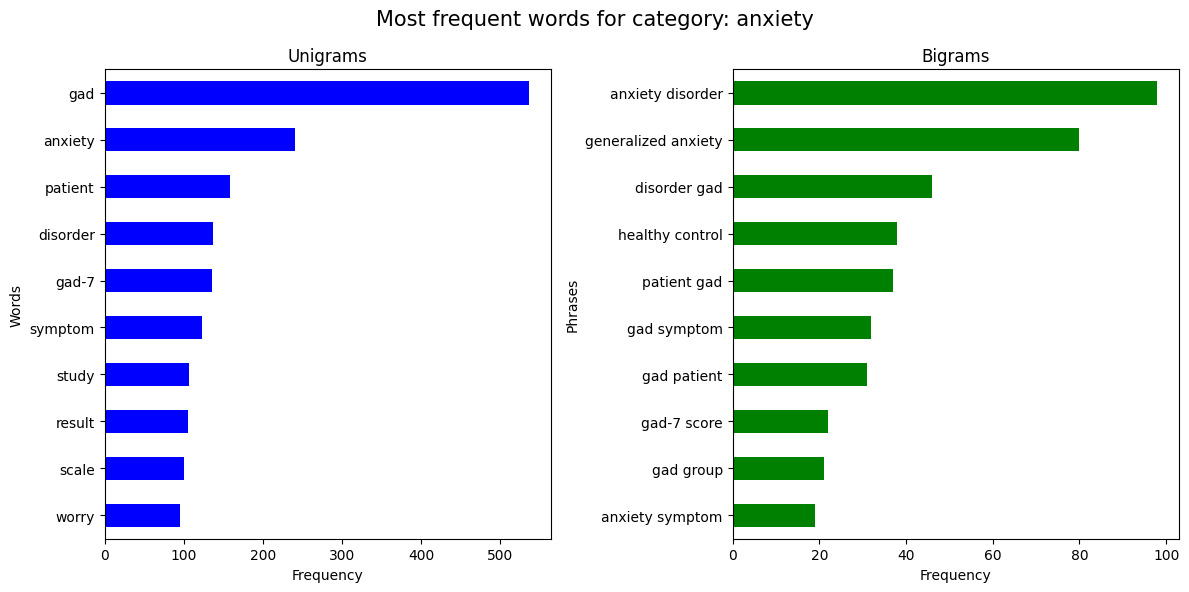

Generating word frequency plot for category: depression


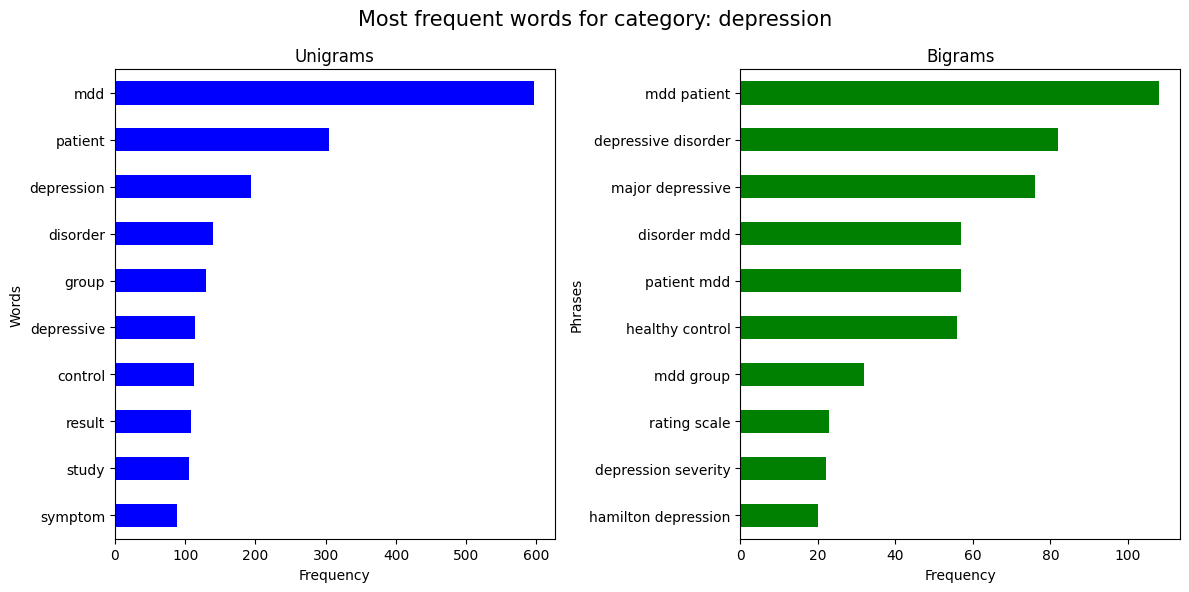

Generating word frequency plot for category: PTSD


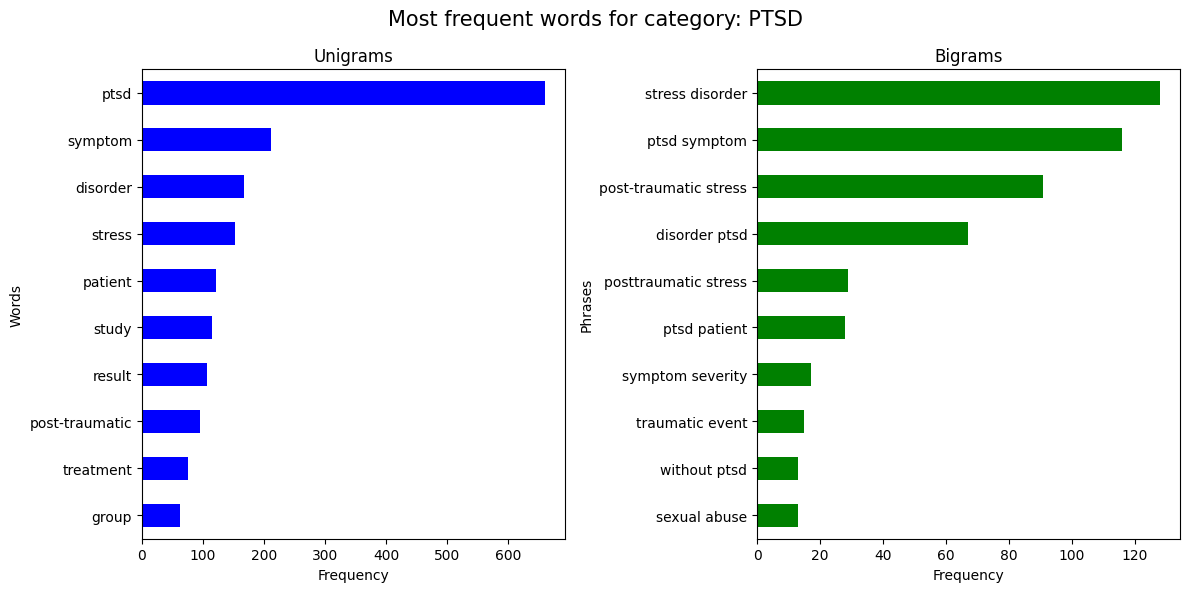

Generating word frequency plot for category: OCD


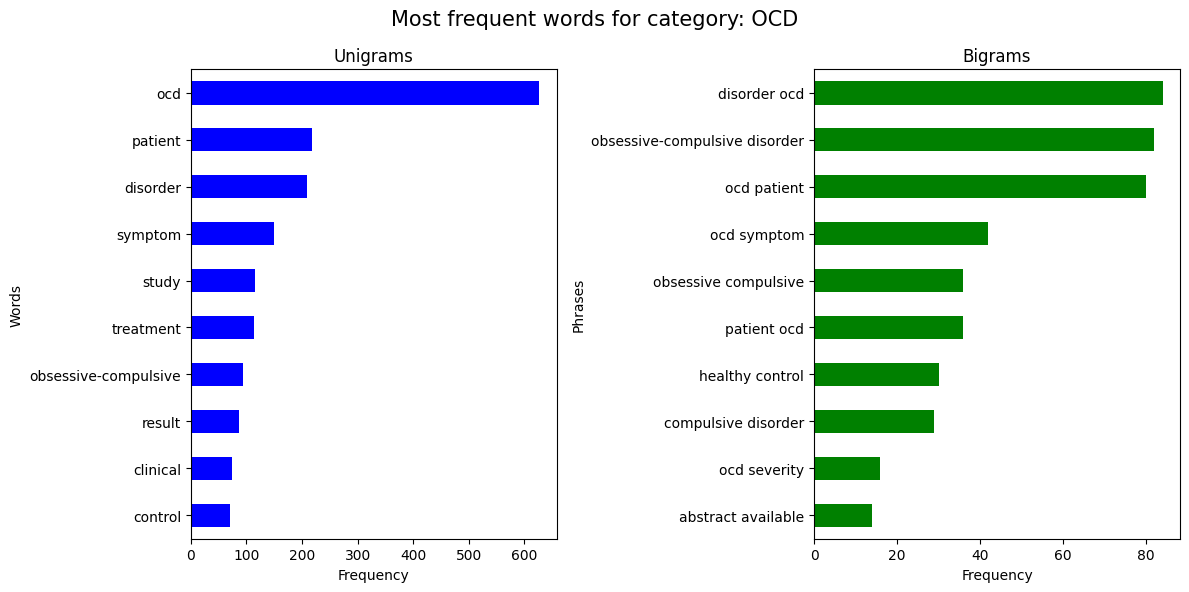

Generating word frequency plot for category: Bipolar


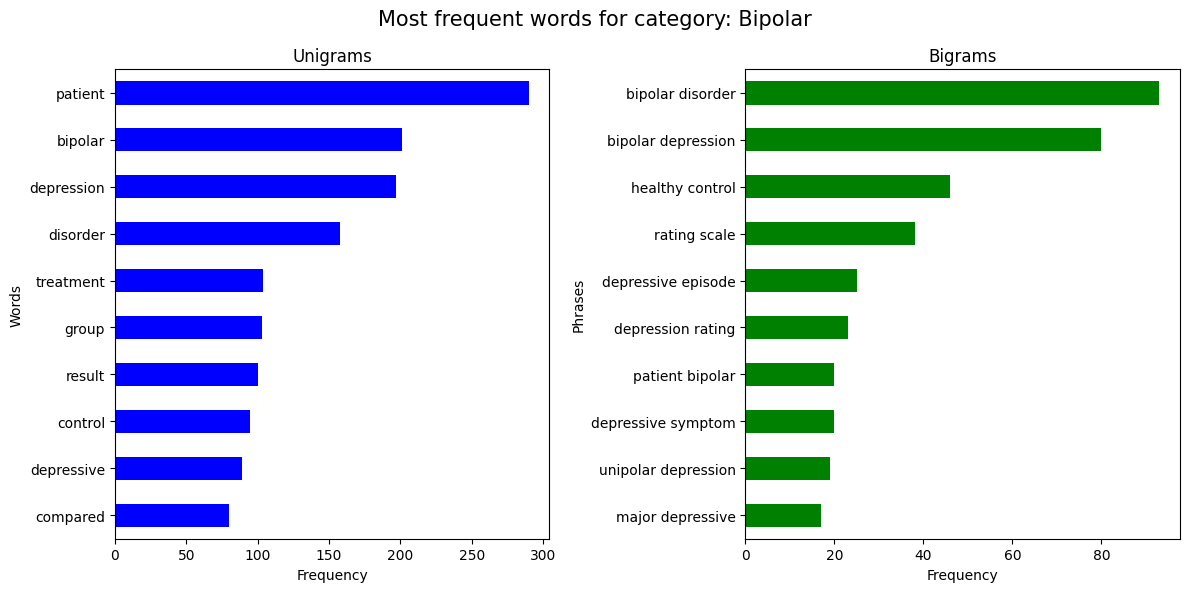

In [ ]:
categories = ["anxiety", "depression", "PTSD", "OCD", "Bipolar"]

for category in categories:
    print(f"Generating word frequency plot for category: {category}")

    plot_word_count(
    data=prepared_dataset,
    label_col = "label",
    text_col = "processed_text",
    category = category,
    top=10)



In [ ]:
def generate_wordcloud(data, label_col, text_col, category):

    corpus = data[data[label_col] == category][text_col]
    if corpus.empty:
        print(f"No data found for category: {category}")
        return

    text = " ".join(corpus)

    wc = WordCloud(background_color='black', max_words=100, max_font_size=35)
    wc = wc.generate(text)

    plt.figure(figsize=(10, 6))
    plt.axis('off')
    plt.imshow(wc, interpolation='bilinear', cmap=None)
    plt.title(f"Word Cloud for Category: {category}", fontsize=16)
    plt.show()


Generating word frequency plot for category: anxiety


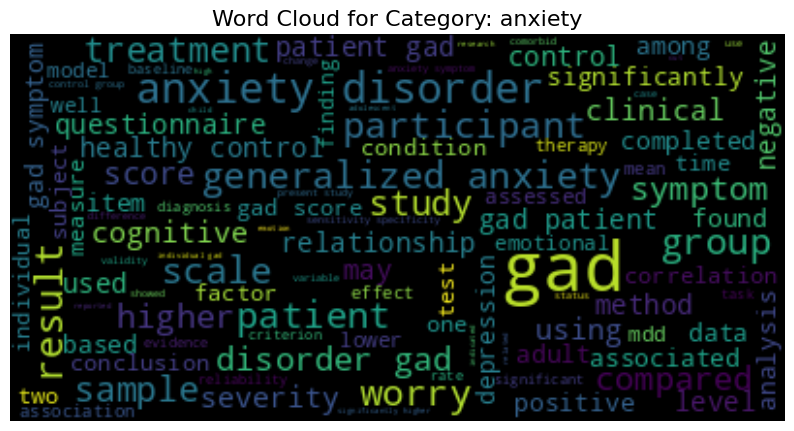

Generating word frequency plot for category: depression


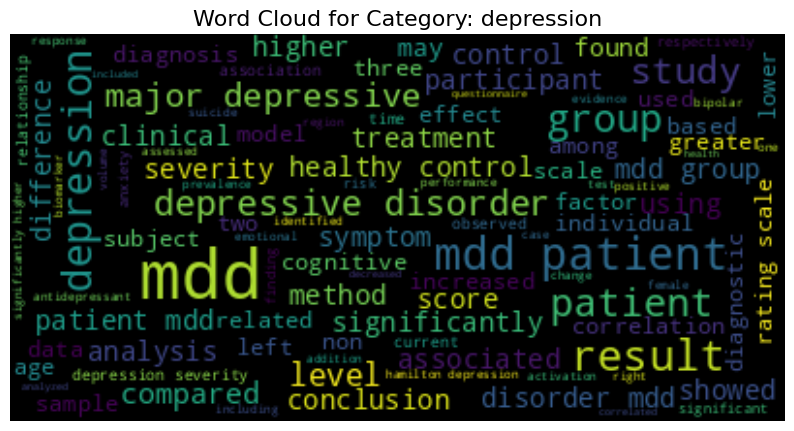

Generating word frequency plot for category: PTSD


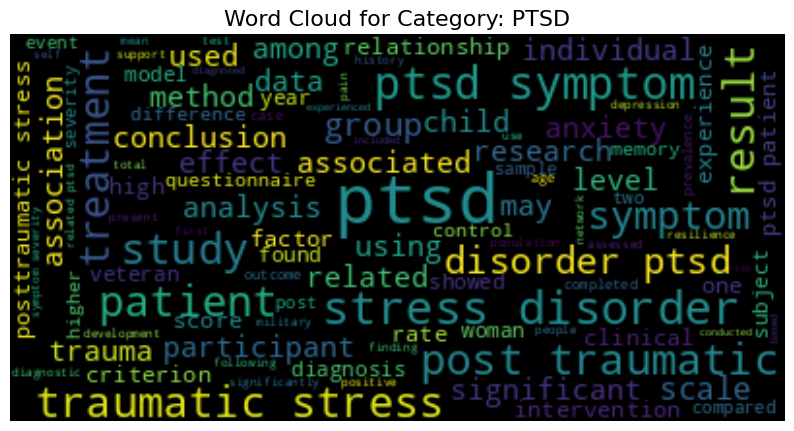

Generating word frequency plot for category: OCD


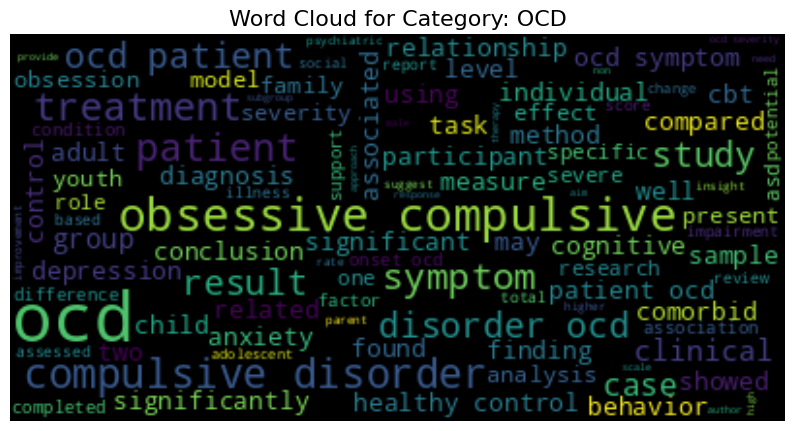

Generating word frequency plot for category: Bipolar


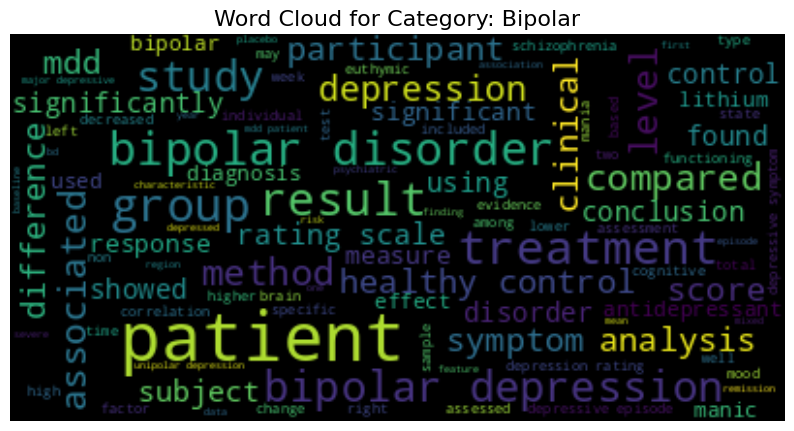

In [ ]:
for category in categories:
    print(f"Generating word frequency plot for category: {category}")

    generate_wordcloud(
    data=prepared_dataset,
    label_col = "label",
    text_col = "processed_text",
    category = category,
    )

# Feature Engeering


In the subsequent code, since the dataset is randomly generated each time the earlier code is executed, we saved the first generated dataset after preprocessing it. This ensures that the same dataset is consistently used in all subsequent parts of the code

Seperate the dataset into train and test

In [ ]:
x = prepared_dataset['processed_text']
y = prepared_dataset['label']
year = prepared_dataset['Year']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

Bag of word

In [ ]:
count_vect = CountVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{2,}\b',
                             ngram_range=(1, 2), max_features = 10000)
X_train_bow = count_vect.fit_transform(x_train)
X_test_bow = count_vect.transform(x_test)
print(X_train_bow.shape)

(800, 10000)


TF-IDF

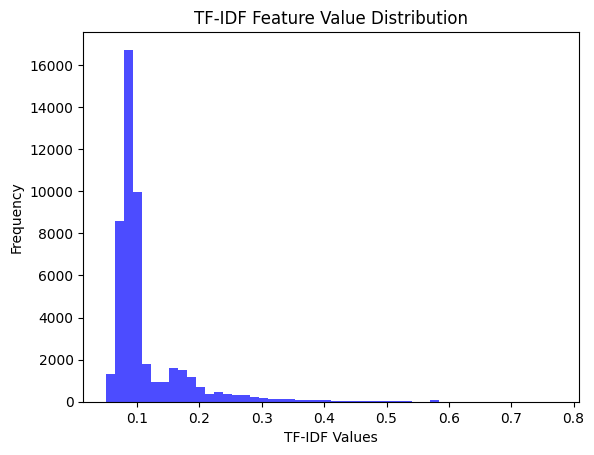

(800, 10000)
features: ['aardema' 'abdominal' 'aberrant' 'ability' 'able' 'able stop' 'abnormal'
 'abnormal reho' 'abnormal resting' 'abnormality']


In [ ]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_bow)
X_train_tf = tf_transformer.transform(X_train_bow)
X_test_tf = tf_transformer.transform(X_test_bow)


tfidf_values = X_train_tf.data
plt.hist(tfidf_values, bins=50, color='blue', alpha=0.7)

plt.title("TF-IDF Feature Value Distribution")
plt.xlabel("TF-IDF Values")
plt.ylabel("Frequency")

plt.show()
print(X_train_tf.shape)
print("features:", count_vect.get_feature_names_out()[:10])

Only a small number of words have high TF-IDF values, which means that these words are very important in certain documents

# Model





## Naive Bayes


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_model = MultinomialNB()
nb_model.fit(X_train_tf, y_train)
y_pred_nb = nb_model.predict(X_test_tf)

print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

     Bipolar       0.97      0.78      0.86        40
         OCD       0.90      0.95      0.93        40
        PTSD       1.00      0.97      0.99        40
     anxiety       0.95      1.00      0.98        40
  depression       0.87      0.97      0.92        40

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



NB model's overall accuracy is 0.94

Confision matrix

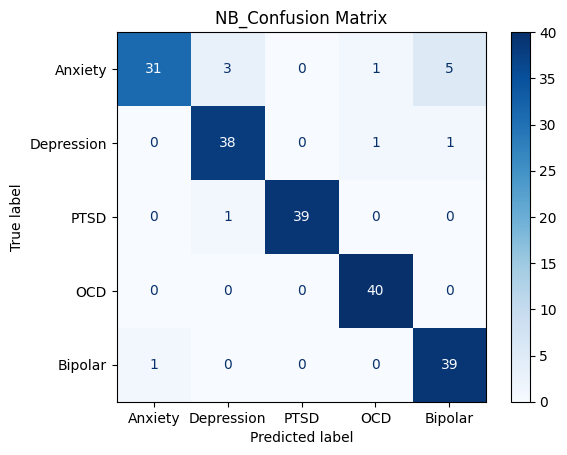

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
class_names = ['Anxiety', 'Depression', 'PTSD', 'OCD', 'Bipolar']

NB_cm = confusion_matrix(y_test, y_pred_nb)

ConfusionMatrixDisplay(confusion_matrix = NB_cm, display_labels=class_names).plot(cmap='Blues')
plt.title("NB_Confusion Matrix")
plt.show()

## SVM


In [ ]:

from nltk.classify import SklearnClassifier
from sklearn.svm import SVC

train_data = [
    (dict(zip(count_vect.get_feature_names_out(), row.toarray()[0])), label)
    for row, label in zip(X_train_tf, y_train)
]

test_data = [
    dict(zip(count_vect.get_feature_names_out(), row.toarray()[0]))
    for row in X_test_tf
]


svm_model = SklearnClassifier(SVC(), sparse=False).train(train_data)
svm_predictions = svm_model.classify_many(test_data)
print(classification_report(y_test, svm_predictions))


SVM_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {SVM_accuracy:.4f}")

              precision    recall  f1-score   support

     Bipolar       0.87      0.82      0.85        40
         OCD       0.93      0.97      0.95        40
        PTSD       1.00      0.97      0.99        40
     anxiety       0.97      0.97      0.97        40
  depression       0.88      0.90      0.89        40

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200

SVM Accuracy: 0.9300


SVM model's overall accuracy is 93%

Confusion matrix

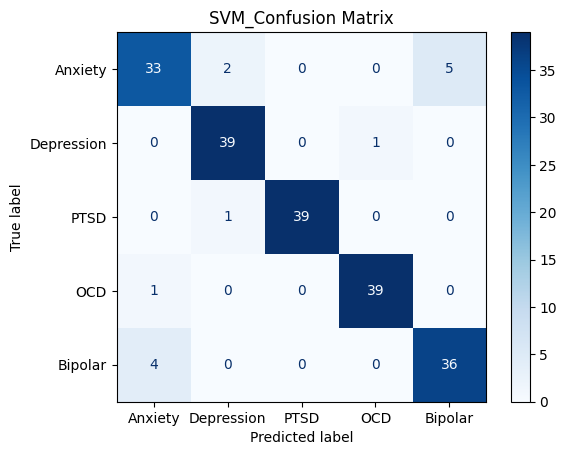

In [ ]:
SVM_cm = confusion_matrix(y_test, svm_predictions)

ConfusionMatrixDisplay(confusion_matrix = SVM_cm, display_labels = class_names).plot(cmap='Blues')
plt.title("SVM_Confusion Matrix")
plt.show()

## Random forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tf, y_train)
y_pred_rf = rf_model.predict(X_test_tf)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

     Bipolar       0.94      0.82      0.88        40
         OCD       0.93      0.95      0.94        40
        PTSD       0.97      0.97      0.97        40
     anxiety       0.98      1.00      0.99        40
  depression       0.88      0.95      0.92        40

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



Random forest model's accuracy is 94%

Confusion matrix

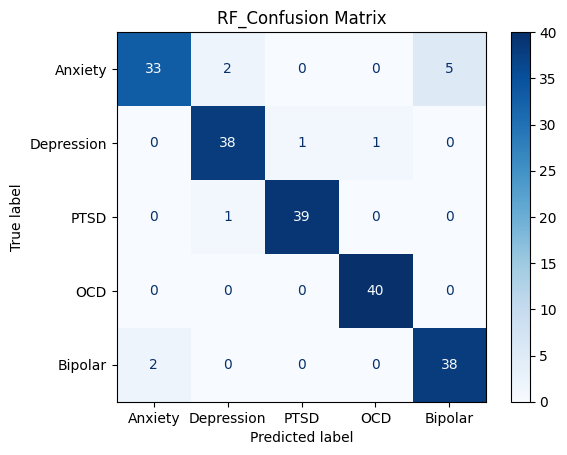

In [ ]:
RF_cm = confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(confusion_matrix = RF_cm, display_labels = class_names).plot(cmap='Blues')
plt.title("RF_Confusion Matrix")
plt.show()

## K-Nearest neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tf, y_train)
y_pred_knn = knn_model.predict(X_test_tf)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

     Bipolar       0.85      0.72      0.78        40
         OCD       0.90      0.93      0.91        40
        PTSD       0.93      0.95      0.94        40
     anxiety       0.91      0.97      0.94        40
  depression       0.85      0.88      0.86        40

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



K-Nearest neighbor model's accuracy is 89%

Confusion matrix

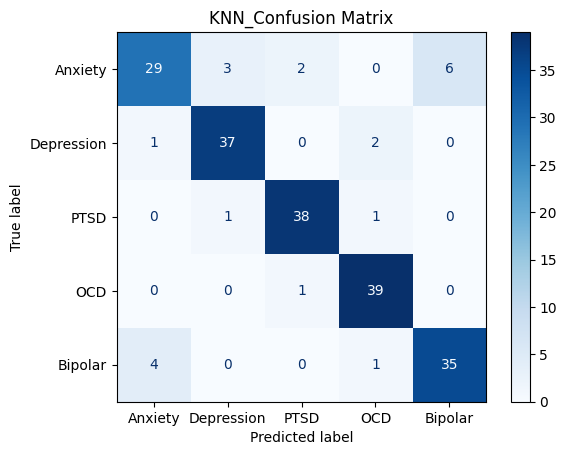

In [ ]:
KNN_cm = confusion_matrix(y_test, y_pred_knn)

ConfusionMatrixDisplay(confusion_matrix = KNN_cm, display_labels = class_names).plot(cmap='Blues')
plt.title("KNN_Confusion Matrix")
plt.show()

## SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)

sgd_model.fit(X_train_tf, y_train)
y_pred_sgd = sgd_model.predict(X_test_tf)

print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

     Bipolar       0.89      0.82      0.86        40
         OCD       0.93      0.97      0.95        40
        PTSD       1.00      0.97      0.99        40
     anxiety       0.98      1.00      0.99        40
  depression       0.88      0.90      0.89        40

    accuracy                           0.94       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.94      0.93       200



SGD model's accuracy is 93%

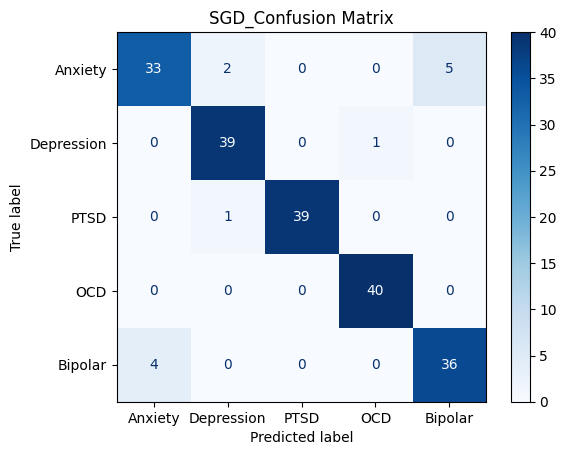

In [ ]:
SGD_cm = confusion_matrix(y_test, y_pred_sgd)

ConfusionMatrixDisplay(confusion_matrix = SGD_cm, display_labels = class_names).plot(cmap='Blues')
plt.title("SGD_Confusion Matrix")
plt.show()

## BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    prepared_dataset['Abstract'], prepared_dataset['label'],
    test_size=0.2, random_state=42, stratify=prepared_dataset['label']
)

print(X_train.shape)
print(X_test.shape)

(800,)
(200,)


In [ ]:
tokennizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(prepared_dataset['label'].unique())
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Convert string labels to numerical values
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if hasattr(self.texts, 'iloc') else str(self.texts[idx])
        label = self.encoded_labels[idx]

        # Tokenize with proper padding and truncation
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_dataset = TextClassificationDataset(list(X_train), list(y_train), tokennizer)
test_dataset = TextClassificationDataset(list(X_test), list(y_test), tokennizer)

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
     output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    eval_accumulation_steps=4,
    fp16=True,
    dataloader_num_workers=0,
    save_strategy="no",
    report_to="none",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    warmup_steps=50,
    weight_decay=0.01,
    max_grad_norm=1.0
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
         'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='macro'),
        'recall': recall_score(labels, preds, average='macro'),
        'f1': f1_score(labels, preds, average='macro')
      }

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

In [ ]:
metrics = trainer.evaluate()

results = pd.DataFrame([metrics])
print(results)

## XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)
        self.label_encoder = LabelEncoder()

    def fit(self, X, y, **kwargs):
        # Encode labels and store classes
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        self.model.fit(X, y_encoded, **kwargs)
        return self

    def predict(self, X):
        predictions = self.model.predict(X)
        return self.label_encoder.inverse_transform(predictions)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

best_model = SklearnXGBClassifier(random_state=42)
best_model.fit(X_train_tf, y_train)
y_pred_xgb = best_model.predict(X_test_tf)

print("Best Model Performance:")
print(classification_report(y_test, y_pred_xgb))

Best Model Performance:
              precision    recall  f1-score   support

     Bipolar       0.85      0.82      0.84        40
         OCD       0.93      0.93      0.93        40
        PTSD       1.00      0.95      0.97        40
     anxiety       0.97      0.95      0.96        40
  depression       0.84      0.93      0.88        40

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



XGBoost model's accuracy is 92%

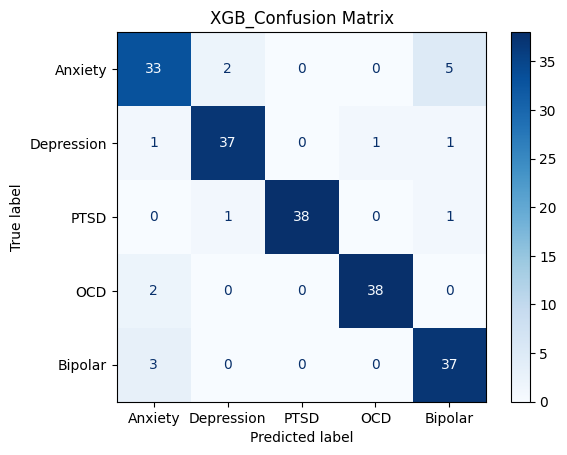

In [ ]:
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = class_names).plot(cmap='Blues')
plt.title("XGB_Confusion Matrix")
plt.show()

# Performance evaluation: cross-validation

In [ ]:
from sklearn.metrics import precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict

def evaluate_models(models, X, y, cv=10):
    results = []
    for model_name, model in models.items():
        # Use cross_val_predict to get predictions
        y_pred = cross_val_predict(model, X, y, cv=cv)

        # Calculate metrics
        precision = precision_score(y, y_pred, average='macro')
        f1 = f1_score(y, y_pred, average='macro')
        accuracy = accuracy_score(y, y_pred)

        # Append results
        results.append({
            'Model': model_name,
            'Mean Accuracy (CV)': accuracy,
            'Precision': precision,
            'F1 Score': f1
        })
    return pd.DataFrame(results)

models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'SGD': SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None),
    'SVM': SVC(),
}

# Use dense matrix for SVM if needed
try:
    X_train_dense = X_train_tf.toarray()
except AttributeError:
    X_train_dense = X_train_tf

# Evaluate models
cv_results = evaluate_models(models, X_train_tf, y_train, cv=10)
print(cv_results)


                 Model  Mean Accuracy (CV)  Precision  F1 Score
0          Naive Bayes             0.90000   0.904321  0.897670
1        Random Forest             0.92375   0.924715  0.922976
2  K-Nearest Neighbors             0.87875   0.878265  0.876803
3                  SGD             0.92250   0.922570  0.922453
4                  SVM             0.92125   0.924143  0.921792


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,7],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100]
}

grid = GridSearchCV(
    SklearnXGBClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring='accuracy',
    verbose=1
)

grid.fit(X_train_tf, y_train)

print("\nGrid Search Results:")
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

y_pred_best = grid.predict(X_test_tf)
print("\nBest Model Performance:")
print(classification_report(y_test, y_pred_best))

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Grid Search Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Validation Score: 0.9275

Best Model Performance:
              precision    recall  f1-score   support

     Bipolar       0.89      0.82      0.86        40
         OCD       0.93      0.93      0.93        40
        PTSD       0.97      0.97      0.97        40
     anxiety       0.97      0.95      0.96        40
  depression       0.86      0.95      0.90        40

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



In [ ]:
xgb_mean_score = grid.best_score_
xgb_std_dev = grid.cv_results_['std_test_score'][grid.best_index_]

from sklearn.metrics import classification_report

# Assuming y_test and y_pred_xgb are available for XGBoost predictions
xgb_classification_report = classification_report(y_test, y_pred_best, output_dict=True)

# Extract precision and F1-score (macro average as an example)
xgb_precision = xgb_classification_report['macro avg']['precision']
xgb_f1_score = xgb_classification_report['macro avg']['f1-score']



xgboost_result = {
    'Model': 'XGBoost',
    'Mean Accuracy (CV)': grid.best_score_,
    'Precision': xgb_precision,
    'F1 Score': xgb_f1_score,
}
xgboost_df = pd.DataFrame([xgboost_result])

final_results_df = pd.concat([pd.DataFrame([xgboost_result]), cv_results])

print(final_results_df)



                 Model  Mean Accuracy (CV)  Precision  F1 Score
0              XGBoost             0.92750   0.925977  0.924786
0          Naive Bayes             0.90000   0.904321  0.897670
1        Random Forest             0.92375   0.924715  0.922976
2  K-Nearest Neighbors             0.87875   0.878265  0.876803
3                  SGD             0.92250   0.922570  0.922453
4                  SVM             0.92125   0.924143  0.921792


XGBoost is the champion model

# Error analysis for XGBoost


In [ ]:
y_pred_best = grid.predict(X_test_tf)
errors_df = pd.DataFrame({
    'Text': X_test_tf,
    'Actual': y_test,
    'Predicted': y_pred_best
})

errors_df['Is_Error'] = errors_df['Actual'] != errors_df['Predicted']
errors = errors_df[errors_df['Is_Error']]
print(errors)

                                                  Text      Actual  \
741    (0, 223)\t0.08574929257125441\n  (0, 225)\t0...         OCD   
545    (0, 89)\t0.2750095491084634\n  (0, 494)\t0.0...     Bipolar   
751    (0, 51)\t0.0936585811581694\n  (0, 301)\t0.0...     Bipolar   
610    (0, 396)\t0.25819888974716115\n  (0, 399)\t0...     anxiety   
655    (0, 13)\t0.5773502691896258\n  (0, 14)\t0.57...     Bipolar   
388    (0, 96)\t0.09090909090909091\n  (0, 443)\t0....     Bipolar   
817    (0, 111)\t0.05439282932204212\n  (0, 211)\t0...         OCD   
89     (0, 17)\t0.12909944487358055\n  (0, 494)\t0....  depression   
852    (0, 89)\t0.4123930494211613\n  (0, 92)\t0.08...     Bipolar   
544    (0, 396)\t0.25819888974716115\n  (0, 399)\t0...     anxiety   
258    (0, 13)\t0.5773502691896258\n  (0, 14)\t0.57...     Bipolar   
627    (0, 41)\t0.08084520834544433\n  (0, 193)\t0....     Bipolar   
701    (0, 480)\t0.08638684255813601\n  (0, 633)\t0...         OCD   
728    (0, 211)\t0.0

In [ ]:
error_rate = errors_df['Is_Error'].mean()
print(f"Overall Error Rate: {error_rate:.2%}")

category_errors = errors_df.groupby('Actual')['Is_Error'].sum()
print("Errors by Category:")
print(category_errors)

Overall Error Rate: 7.50%
Errors by Category:
Actual
Bipolar       7
OCD           3
PTSD          1
anxiety       2
depression    2
Name: Is_Error, dtype: int64


The most errors occur when detecting bipolar class

#Baseline Deviation Analysis (Year + Age Group)

In [ ]:
df_baseline = prepared_dataset.copy()
bins = [0, 1999, 2009, 2019, 2100]
year_labels = ['Before2000', '2000-2009', '2010-2019', '2020+']
df_baseline['year_group'] = pd.cut(df_baseline['Year'], bins=bins, labels=year_labels)

df_baseline['Combined_Keywords'] = (
    df_baseline['Index Keywords'].fillna('') + ' ' +
    df_baseline['Author Keywords'].fillna('') + ' ' +
    df_baseline['Title'].fillna('')
)

age_keywords = {
    "Infant/Toddler": ["infant", "toddler", "preschool", "baby"],
    "Child": ["child", "children"],
    "Adolescent": ["teen", "teenager", "adolescent", "youth"],
    "Young Adult": ["young adult", "college", "university student"],
    "Middle Aged": ["middle aged", "middle-age"],
    "Elderly": ["elderly", "aged", "older adult", "senior"],
}
def extract_age_group(text):
    txt = str(text).lower()
    for ag, kw_list in age_keywords.items():
        if any(k in txt for k in kw_list):
            return ag
    if "adult" in txt:
        return "Adult"
    return "Unknown"

df_baseline['age_group'] = df_baseline['Combined_Keywords'].apply(extract_age_group)

In [ ]:
df_baseline = df_baseline.reset_index(drop=True)
x_for_split = df_baseline['processed_text']
y_for_split = df_baseline['label']
x_train_idx, x_test_idx, _, _ = train_test_split(
    df_baseline.index, df_baseline['label'],
    test_size=0.2, random_state=42, stratify=df_baseline['label']
)

test_df_baseline = df_baseline.loc[x_test_idx].copy()

X_test_bow_baseline = count_vect.transform(test_df_baseline['processed_text'])
X_test_tf_baseline = tf_transformer.transform(X_test_bow_baseline)

test_preds = best_model.predict(X_test_tf_baseline)
test_df_baseline['predicted'] = test_preds

year group

In [ ]:
for yg in test_df_baseline['year_group'].unique():
    subset = test_df_baseline[test_df_baseline['year_group'] == yg]
    if len(subset)==0:
        continue
    acc_ = accuracy_score(subset['label'], subset['predicted'])
    print(f"Year Group = {yg}, Sample Size={len(subset)}, Accuracy={acc_:.3f}")


Year Group = 2010-2019, Sample Size=107, Accuracy=0.925
Year Group = 2020+, Sample Size=93, Accuracy=0.903


age group

In [ ]:
for ag in test_df_baseline['age_group'].unique():
    subset = test_df_baseline[test_df_baseline['age_group'] == ag]
    if len(subset)==0:
        continue
    acc_ = accuracy_score(subset['label'], subset['predicted'])
    print(f"Age Group = {ag}, Sample Size={len(subset)}, Accuracy={acc_:.3f}")


Age Group = Adult, Sample Size=48, Accuracy=0.917
Age Group = Unknown, Sample Size=58, Accuracy=0.879
Age Group = Young Adult, Sample Size=13, Accuracy=1.000
Age Group = Child, Sample Size=23, Accuracy=0.913
Age Group = Middle Aged, Sample Size=26, Accuracy=0.846
Age Group = Elderly, Sample Size=12, Accuracy=1.000
Age Group = Adolescent, Sample Size=17, Accuracy=1.000
Age Group = Infant/Toddler, Sample Size=3, Accuracy=1.000


report

In [ ]:
print("\nDetailed classification report for entire test set:")
print(classification_report(test_df_baseline['label'], test_df_baseline['predicted']))


Detailed classification report for entire test set:
              precision    recall  f1-score   support

     Bipolar       0.85      0.82      0.84        40
         OCD       0.93      0.93      0.93        40
        PTSD       1.00      0.95      0.97        40
     anxiety       0.97      0.95      0.96        40
  depression       0.84      0.93      0.88        40

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



#Reduce accuracy (remove diagnostic words + truncate text + reduce features)


Implement multiple strategies to reduce accuracy: feature reduction, noise injection, feature dropout around 20%

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [ ]:
DIAGNOSTIC_TERMS = {
    'anxiety': ['anxiety', 'anxious', 'panic', 'worry', 'fear', 'nervous'],
    'depression': ['depression', 'depressive', 'depressed', 'mood', 'sadness'],
    'ptsd': ['ptsd', 'trauma', 'post-traumatic', 'post traumatic', 'stress disorder'],
    'ocd': ['ocd', 'obsessive', 'compulsive', 'obsessive-compulsive', 'ritual'],
    'bipolar': ['bipolar', 'mania', 'manic', 'mood disorder', 'cyclothymia']
}
all_diagnostic_terms = set()
for terms in DIAGNOSTIC_TERMS.values():
    all_diagnostic_terms.update([t.lower() for t in terms])

After removing professional words (diagnostic terms), the accuracy of xgboost is 78%

-**14**%

In [ ]:
def remove_diagnostic_terms(text, category):
    if pd.isna(text):
        return ""
    text = text.lower()
    pattern = r'(?i)\b(' + '|'.join(re.escape(term) for term in all_diagnostic_terms) + r')\b'

    text = re.sub(pattern, '', text).strip()
    return text

# Remove diagnostic terms from all processed text
prepared_dataset['processed_text_modified'] = prepared_dataset.apply(lambda row: remove_diagnostic_terms(row['processed_text'], row['label']), axis=1)

X = prepared_dataset['processed_text_modified']
y = prepared_dataset['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Evaluate performance after remove Feature Manipulation:
label_encoder.fit(prepared_dataset['label'])
best_model.fit(X_train_tf, y_train)
y_pred = best_model.predict(X_test_tf)

acc_no_diag = accuracy_score(y_test, y_pred)
print("[1] Accuracy after removing diagnostic terms:", acc_no_diag)
print(classification_report(y_test, y_pred))

[1] Accuracy after removing diagnostic terms: 0.915
              precision    recall  f1-score   support

     Bipolar       0.85      0.82      0.84        40
         OCD       0.93      0.93      0.93        40
        PTSD       1.00      0.95      0.97        40
     anxiety       0.97      0.95      0.96        40
  depression       0.84      0.93      0.88        40

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



reduce model accuracy： 64%   -28%

In [ ]:
def reduce_features(X_train, X_test, feature_ratio=0.5):
    n_features = int(X_train.shape[1] * feature_ratio)
    return X_train[:, :n_features], X_test[:, :n_features]

In [ ]:
X_train_reduced, X_test_reduced = reduce_features(X_train_tf, X_test_tf)

xgb_reduced = SklearnXGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=100, random_state=42)

xgb_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = xgb_reduced.predict(X_test_reduced)

acc_reduced = accuracy_score(y_test, y_pred_reduced)
print("[2] Accuracy after feature reduction (50%):", acc_reduced)
print(classification_report(y_test, y_pred_reduced))

[2] Accuracy after feature reduction (50%): 0.835
              precision    recall  f1-score   support

     Bipolar       0.94      0.80      0.86        40
         OCD       0.76      0.70      0.73        40
        PTSD       0.71      0.80      0.75        40
     anxiety       0.97      0.93      0.95        40
  depression       0.83      0.95      0.88        40

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.84       200
weighted avg       0.84      0.83      0.84       200



reduce text length： 75%

In [ ]:
def reduce_document_length(texts, max_length=50):
    return [' '.join(text.split()[:max_length]) for text in texts]


In [ ]:
X_train_short = reduce_document_length(X_train)
X_test_short = reduce_document_length(X_test)

tfidf_short = TfidfVectorizer(max_features=10000)
X_train_short_tfidf = tfidf_short.fit_transform(X_train_short)
X_test_short_tfidf = tfidf_short.transform(X_test_short)

xgb_short = SklearnXGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=100, random_state=42)
xgb_short.fit(X_train_short_tfidf, y_train)
y_pred_short = xgb_short.predict(X_test_short_tfidf)

acc_short = accuracy_score(y_test, y_pred_short)
print("[3] Accuracy after document length reduction (max_length=50):", acc_short)
print(classification_report(y_test, y_pred_short))

[3] Accuracy after document length reduction (max_length=50): 0.75
              precision    recall  f1-score   support

     Bipolar       0.61      0.50      0.55        40
         OCD       0.57      0.57      0.57        40
        PTSD       0.74      0.85      0.79        40
     anxiety       0.97      0.90      0.94        40
  depression       0.84      0.93      0.88        40

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



In [ ]:
def remove_diagnostic_terms(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    pattern = r'(?i)\b(' + '|'.join(re.escape(term) for term in all_diagnostic_terms) + r')\b'
    text = re.sub(pattern, '', text).strip()
    return text

def reduce_document_length(texts, max_length=50):
    return [' '.join(txt.split()[:max_length]) for txt in texts]

modified_dataset = df_final.copy()
# 1) remove
modified_dataset['processed_text_mod'] = modified_dataset['processed_text'].apply(remove_diagnostic_terms)

# 2) short length
modified_dataset['processed_text_mod'] = reduce_document_length(modified_dataset['processed_text_mod'], max_length=50)

modified_dataset.to_csv('/content/modified_dataset.csv', index=False)
modified_dataset.head(2)


,processed_text,label,Year,Title,Abstract,Index Keywords,Author Keywords,processed_text_mod
0,conducted south african college student using ...,PTSD,2020,Reduction of PTSD in South African University ...,A study was conducted on South African college...,Adult; Depressive Disorder; Female; Humans; Ma...,education; meditation; mental health; post-tra...,conducted south african college student using ...
1,study investigated importance social support r...,OCD,2024,Social support in obsessive-compulsive disorde...,Social support is widely beneficial for indivi...,Adult; Female; Humans; Male; Middle Aged; Moti...,obsessive-compulsive disorder; readiness to ch...,study investigated importance social support r...


training champion model

Accuracy after modifications: 0.78
              precision    recall  f1-score   support

     Bipolar       0.64      0.57      0.61        40
         OCD       0.66      0.62      0.64        40
        PTSD       0.78      0.88      0.82        40
     anxiety       0.97      0.90      0.94        40
  depression       0.84      0.93      0.88        40

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



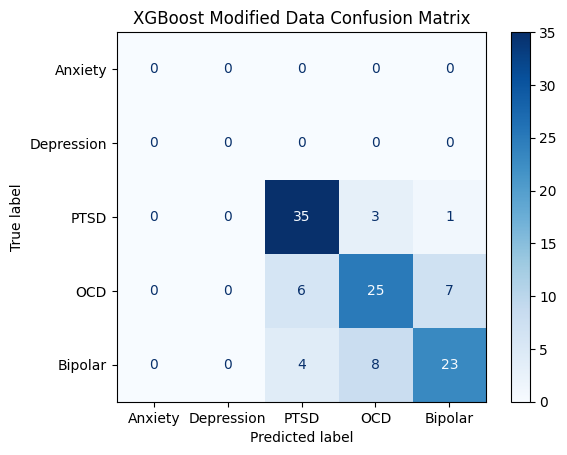

In [ ]:
mod_data = pd.read_csv('/content/modified_dataset.csv')

X_mod = mod_data['processed_text_mod']
y_mod = mod_data['label']

X_train_mod_idx, X_test_mod_idx, y_train_mod, y_test_mod = train_test_split(
    mod_data.index, mod_data['label'],
    test_size=0.2, random_state=42, stratify=mod_data['label']
)

train_mod_df = mod_data.loc[X_train_mod_idx].copy()
test_mod_df = mod_data.loc[X_test_mod_idx].copy()


mod_count_vect = CountVectorizer(stop_words='english', max_features=10000)
X_train_mod_bow = mod_count_vect.fit_transform(train_mod_df['processed_text_mod'])
X_test_mod_bow = mod_count_vect.transform(test_mod_df['processed_text_mod'])

mod_tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_mod_bow)
X_train_mod_tf = mod_tf_transformer.transform(X_train_mod_bow)
X_test_mod_tf = mod_tf_transformer.transform(X_test_mod_bow)

best_model_mod = best_model
best_model_mod.fit(X_train_mod_tf, y_train_mod)

y_pred_mod = best_model_mod.predict(X_test_mod_tf)
acc_mod = accuracy_score(y_test_mod, y_pred_mod)
print("Accuracy after modifications:", acc_mod)
print(classification_report(y_test_mod, y_pred_mod))
cm_mod = confusion_matrix(y_test_mod, y_pred_mod, labels=class_names)
ConfusionMatrixDisplay(confusion_matrix=cm_mod, display_labels=class_names).plot(cmap='Blues')
plt.title("XGBoost Modified Data Confusion Matrix")
plt.show()


# Bias Analysis（year，agegroup） after data maged

In [ ]:
mod_data['year_group'] = pd.cut(mod_data['Year'], bins=bins, labels=year_labels)
def extract_age_group2(text):
    txt = str(text).lower()
    for ag, kw_list in age_keywords.items():
        if any(k in txt for k in kw_list):
            return ag
    if "adult" in txt:
        return "Adult"
    return "Unknown"

In [ ]:
mod_data['Combined_Keywords'] = (
    mod_data['Index Keywords'].fillna('') + ' ' +
    mod_data['Author Keywords'].fillna('') + ' ' +
    mod_data['Title'].fillna('')
)
mod_data['age_group'] = mod_data['Combined_Keywords'].apply(extract_age_group2)

test_mod_df = mod_data.loc[X_test_mod_idx].copy()
test_mod_df['predicted'] = y_pred_mod

In [ ]:
print("===== Modified Data Bias Analysis =====")
for yg in test_mod_df['year_group'].unique():
    subset = test_mod_df[test_mod_df['year_group'] == yg]
    if len(subset)==0:
        continue
    acc_ = accuracy_score(subset['label'], subset['predicted'])
    print(f"Year Group = {yg}, sample={len(subset)}, Accuracy={acc_:.3f}")

for ag in test_mod_df['age_group'].unique():
    subset = test_mod_df[test_mod_df['age_group'] == ag]
    if len(subset)==0:
        continue
    acc_ = accuracy_score(subset['label'], subset['predicted'])
    print(f"Age Group = {ag}, sample={len(subset)}, Accuracy={acc_:.3f}")

print("\nDetailed classification report (modified data):")
print(classification_report(test_mod_df['label'], test_mod_df['predicted']))

===== Modified Data Bias Analysis =====
Year Group = 2010-2019, sample=107, Accuracy=0.748
Year Group = 2020+, sample=93, Accuracy=0.817
Age Group = Adult, sample=48, Accuracy=0.812
Age Group = Unknown, sample=58, Accuracy=0.707
Age Group = Young Adult, sample=13, Accuracy=0.923
Age Group = Child, sample=23, Accuracy=0.696
Age Group = Middle Aged, sample=26, Accuracy=0.769
Age Group = Elderly, sample=12, Accuracy=0.917
Age Group = Adolescent, sample=17, Accuracy=0.824
Age Group = Infant/Toddler, sample=3, Accuracy=1.000

Detailed classification report (modified data):
              precision    recall  f1-score   support

     Bipolar       0.64      0.57      0.61        40
         OCD       0.66      0.62      0.64        40
        PTSD       0.78      0.88      0.82        40
     anxiety       0.97      0.90      0.94        40
  depression       0.84      0.93      0.88        40

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78  

   Scenario  Accuracy
0  Baseline     0.915
1  Modified     0.780


<ipython-input-53-c14a57fed921>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_comparison, x="Scenario", y="Accuracy", palette="Blues")


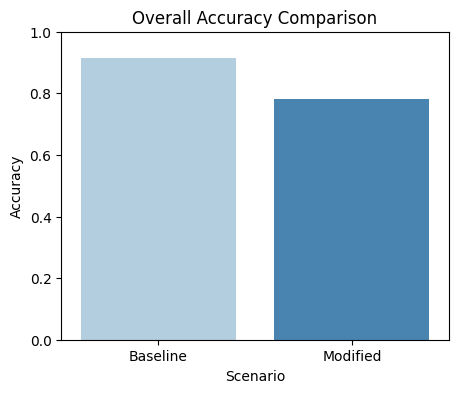

In [ ]:
acc_baseline = accuracy_score(test_df_baseline['label'], test_df_baseline['predicted'])
acc_mod = accuracy_score(test_mod_df['label'], test_mod_df['predicted'])

accuracy_comparison = pd.DataFrame({
    "Scenario": ["Baseline", "Modified"],
    "Accuracy": [acc_baseline, acc_mod]
})

print(accuracy_comparison)

plt.figure(figsize=(5, 4))
sns.barplot(data=accuracy_comparison, x="Scenario", y="Accuracy", palette="Blues")
plt.ylim(0, 1)
plt.title("Overall Accuracy Comparison")
plt.show()